In [1]:
# --------------------------
# 1. Imports
# --------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'torch'

In [5]:
import pandas as pd
data = pd.read_csv("SWaT_Dataset.csv")  # your dataset path
labels = data['State'].map({'Normal':0, 'Attack':1}).values

In [14]:
data['State'].value_counts()

State
Normal     395298
Attack      54584
A ttack        37
Name: count, dtype: int64

In [2]:
# --------------------------
# 2. Load and preprocess data
# --------------------------
data = pd.read_csv("SWaT_Dataset.csv")  # your dataset path
labels = data['State'].map({'Normal':0, 'Attack':1}).values
data = data.drop(columns=['State', ' t_stamp'])  # drop labels and timestamp

# scale features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print("Scaled shape:", data_scaled.shape)


Scaled shape: (449919, 51)


In [3]:
# --------------------------
# 3. Feature reduction (PCA)
# --------------------------
pca = PCA(n_components=20)  # adjust n_components to reduce VRAM
X_reduced = pca.fit_transform(data_scaled)
print("Reduced shape:", X_reduced.shape)


Reduced shape: (449919, 20)


In [4]:
# --------------------------
# 4. Sequence preparation
# --------------------------
SEQ_LEN = 30  # adjust sequence length
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

X_all = create_sequences(X_reduced, SEQ_LEN)
labels_seq = labels[SEQ_LEN:]  # aligned with sequences
print("X_all shape:", X_all.shape)
print("labels_seq shape:", labels_seq.shape)


X_all shape: (449889, 30, 20)
labels_seq shape: (449889,)


In [5]:
# --------------------------
# 5. VRAM-friendly DataLoader
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16  # reduce if OOM

X_tensor = torch.tensor(X_all, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [6]:
# --------------------------
# 6. LSTM Autoencoder
# --------------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_size=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=n_features, batch_first=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        enc_out, (h, c) = self.encoder(x)
        dec_input = torch.zeros(x.size(), device=x.device)
        dec_out, _ = self.decoder(enc_out)
        return dec_out


In [9]:
# --------------------------
# 7. Model training
# --------------------------
model = LSTMAutoencoder(n_features=X_all.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 20  # adjust if VRAM issues

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for (batch,) in loader:
        batch = batch.to(device)
        recon = model(batch)
        loss = criterion(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {epoch_loss/len(loader):.6f}")

Epoch 1/20  Loss: 0.028515
Epoch 2/20  Loss: 0.025524
Epoch 3/20  Loss: 0.025153
Epoch 4/20  Loss: 0.024983
Epoch 5/20  Loss: 0.024916
Epoch 6/20  Loss: 0.024884
Epoch 7/20  Loss: 0.024849
Epoch 8/20  Loss: 0.024820
Epoch 9/20  Loss: 0.024795
Epoch 10/20  Loss: 0.024771
Epoch 11/20  Loss: 0.024746
Epoch 12/20  Loss: 0.024726
Epoch 13/20  Loss: 0.024712
Epoch 14/20  Loss: 0.024702
Epoch 15/20  Loss: 0.024663
Epoch 16/20  Loss: 0.024657
Epoch 17/20  Loss: 0.024656
Epoch 18/20  Loss: 0.024641
Epoch 19/20  Loss: 0.024635
Epoch 20/20  Loss: 0.024633


In [10]:
# --------------------------
# 8. Save model
# --------------------------
torch.save(model.state_dict(), "lstm_autoencoder_small.pth")

In [11]:
# --------------------------
# 9. Evaluation
# --------------------------
model.eval()
all_errors = []

with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        recon = model(batch)
        mse = torch.mean((recon - batch) ** 2, dim=(1,2))
        all_errors.append(mse.cpu().numpy())

errors = np.concatenate(all_errors)
print("Errors shape:", errors.shape)

Errors shape: (449889,)


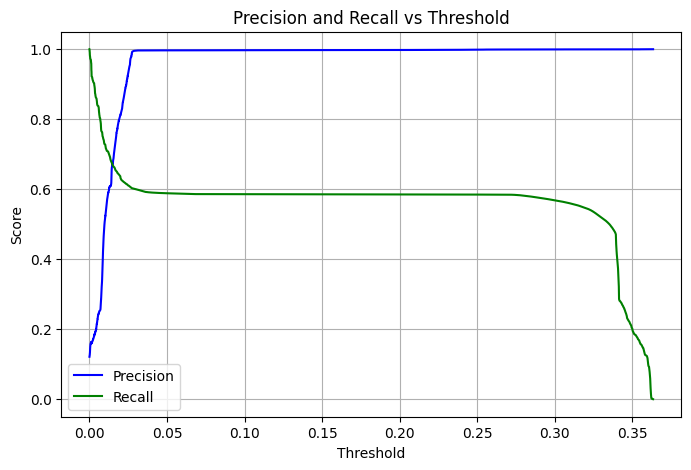

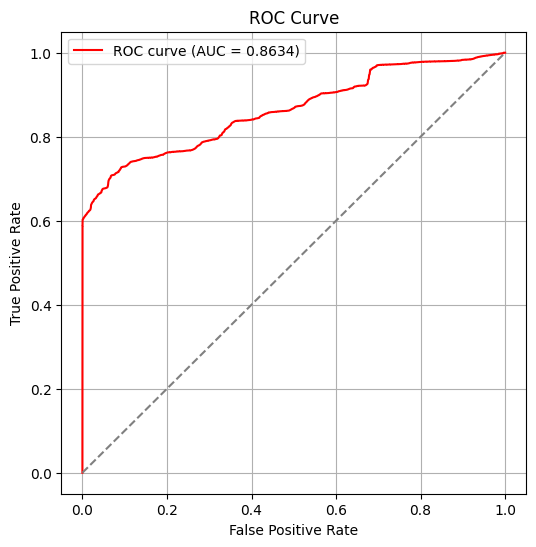

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# -----------------------------
# Precision-Recall vs Threshold
# -----------------------------
precisions, recalls, thresholds_pr = precision_recall_curve(labels_clean, errors_clean)

plt.figure(figsize=(8,5))
plt.plot(thresholds_pr, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds_pr, recalls[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, thresholds_roc = roc_curve(labels_clean, errors_clean)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='red')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Optimal Threshold: 0.029386
Best F1 (at that threshold): 0.7493
Precision: 0.9957
Recall:    0.6006
F1 Score:  0.7493
ROC-AUC:   0.8634


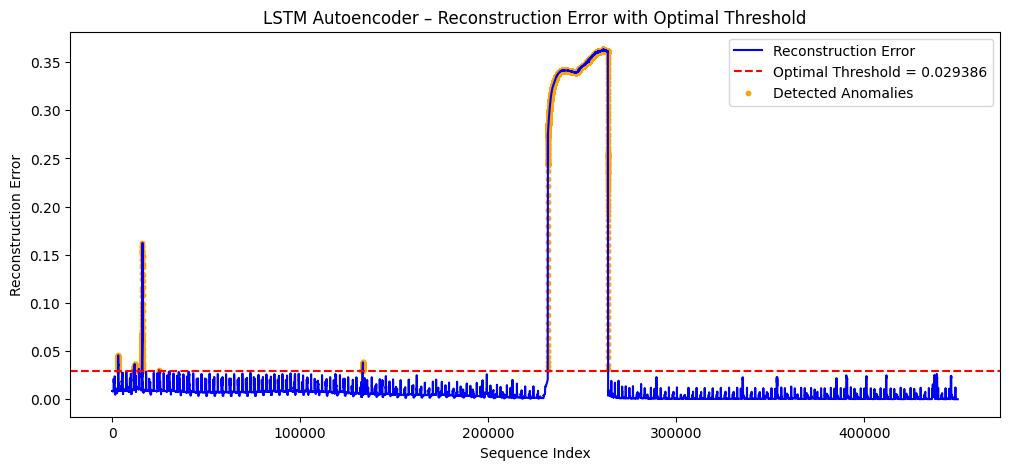

In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Clean and align arrays ---
min_len = min(len(labels_seq), len(errors))
labels_seq = labels_seq[:min_len]
errors     = errors[:min_len]

mask = ~np.isnan(labels_seq)
labels_clean = labels_seq[mask]
errors_clean = errors[mask]

# --- 2. Find optimal threshold that maximizes F1 ---
thresholds = np.linspace(errors_clean.min(), errors_clean.max(), 100)
best_f1 = 0.0
best_threshold = thresholds[0]

for t in thresholds:
    preds_temp = (errors_clean > t).astype(int)
    f1_temp = f1_score(labels_clean, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.6f}")
print(f"Best F1 (at that threshold): {best_f1:.4f}")

# --- 3. Final predictions and metrics at optimal threshold ---
preds_opt = (errors_clean > best_threshold).astype(int)

precision = precision_score(labels_clean, preds_opt)
recall    = recall_score(labels_clean, preds_opt)
f1        = f1_score(labels_clean, preds_opt)
roc_auc   = roc_auc_score(labels_clean, errors_clean)  # continuous errors for ROC

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# --- 4. Plot reconstruction error with optimal threshold ---
plt.figure(figsize=(12,5))
plt.plot(errors_clean, label="Reconstruction Error", color="blue")
plt.axhline(best_threshold, color="red", linestyle="--",
            label=f"Optimal Threshold = {best_threshold:.6f}")
anomaly_idx = np.where(preds_opt == 1)[0]
plt.scatter(anomaly_idx, errors_clean[anomaly_idx],
            color="orange", s=10, label="Detected Anomalies")
plt.title("LSTM Autoencoder – Reconstruction Error with Optimal Threshold")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


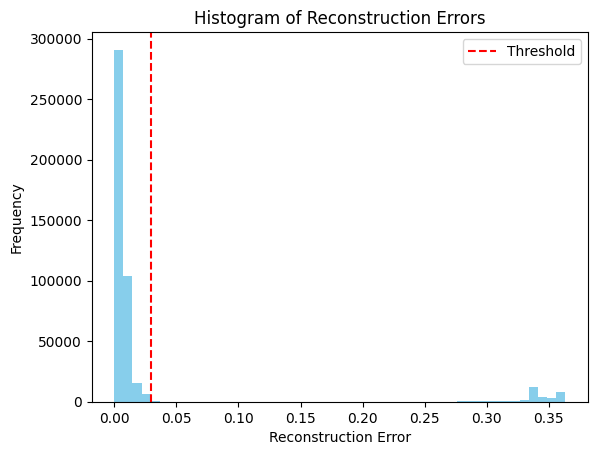

In [9]:
plt.hist(errors_clean, bins=50, color='skyblue')
plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.show()


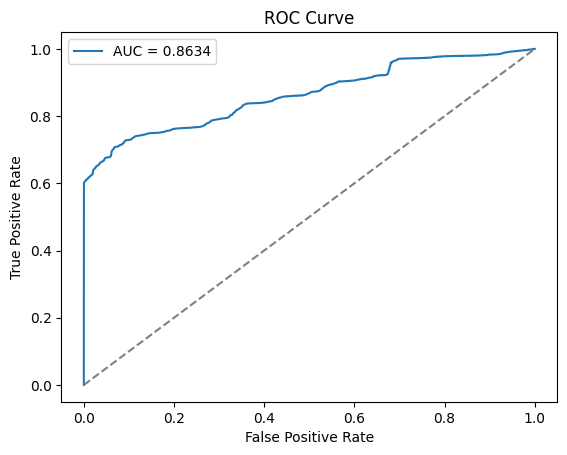

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(labels_clean, errors_clean)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


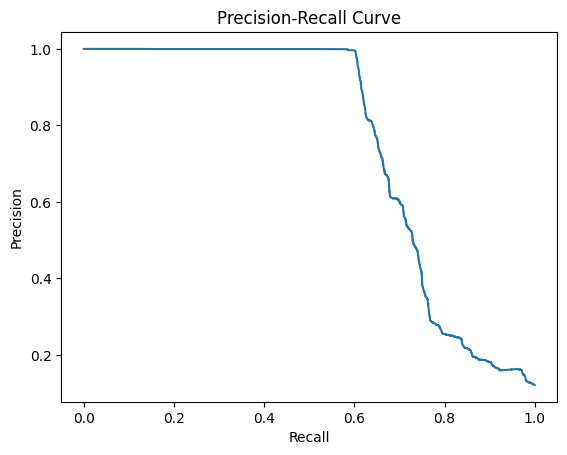

In [11]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, _ = precision_recall_curve(labels_clean, errors_clean)
plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
